# Diabetes Readmission Example
### _Error Analysis_ Workshop for ODSC West Conference 
#### (scheduled for November 2nd, 2022 2:00 PM PST)
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Github](https://github.com/smasis001))

**The Mission**

Diabetes impacts over 9% of the world adult population and growing. It requires constant monitoring and treatment. Some patients pose greater and imminent risks than others.

Imagine you've been asked to create a model that predicts which patients will need to be readmitted in less than 30 days so that the hospital can take more preventative measures with these patients such as prescribe monitoring devices, make earlier appointments and have nurses call them every week. Which measures to take will vary on a case by case basis but nor the hospital nor the patients can afford to have them prescribed by default, which is why model must be selective. Yet patients at risk of being readmitted must be covered by the program as much as possible.


**The Solution**

This notebook will walk through:



- Preparing the data with categorical encoding
- Understanding how class weights can shift error around
- Leveraging hyperparameter tuning with `optuna` to obtain highest recall with some constraints
- Breaking error into different cohorts
- Diving into feature importance and connecting it to this problem
- Navigating error analysis tool to find cohorts with increased error
- Discussing possible error mitigation strategies

## 1) The Preparations

### 1.1) Installing the Libraries

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn

In [ ]:
!pip install raiwidgets lightgbm optuna shap

### 1.2) Loading the Libraries

In [10]:
import math
import os
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods
import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

### 1.3) Understanding the Data

#### 1.3.1) Loading the Data

In [15]:
X_orig, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  float64 
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  float64 
 8   num_procedures            101766 non-null  float64 
 9   num_medications           101766 non-null  float64 
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  float64 
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

In [175]:
X_orig.sample(n=15)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
93171,Caucasian,Male,30-60 years,Discharged to Home,Emergency,6.0,Missing,78.0,6.0,37.0,...,Up,Ch,Yes,False,False,False,False,False,NO,0.0
67264,Caucasian,Female,Over 60 years,Other,Emergency,3.0,Family/GeneralPractice,35.0,0.0,8.0,...,Down,Ch,Yes,True,False,False,True,False,<30,1.0
31447,AfricanAmerican,Female,Over 60 years,Other,Emergency,5.0,Missing,71.0,0.0,21.0,...,No,No,No,True,False,False,False,False,NO,0.0
92932,Caucasian,Male,30-60 years,Discharged to Home,Emergency,3.0,Missing,1.0,2.0,15.0,...,Down,Ch,Yes,False,False,True,False,False,>30,1.0
18598,Caucasian,Male,30-60 years,Other,Emergency,5.0,Family/GeneralPractice,51.0,0.0,10.0,...,No,No,No,False,False,False,False,False,NO,0.0
88448,AfricanAmerican,Female,Over 60 years,Discharged to Home,Emergency,5.0,Missing,65.0,0.0,19.0,...,No,No,Yes,False,False,False,True,True,NO,0.0
88451,Caucasian,Female,Over 60 years,Discharged to Home,Emergency,2.0,InternalMedicine,27.0,0.0,9.0,...,Steady,Ch,Yes,False,False,False,False,False,>30,1.0
61069,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,7.0,Missing,31.0,1.0,24.0,...,No,No,No,False,False,False,False,False,>30,1.0
78673,Caucasian,Male,30-60 years,Discharged to Home,Referral,4.0,Missing,5.0,1.0,35.0,...,Up,Ch,Yes,False,False,False,False,False,NO,0.0
34780,Caucasian,Male,Over 60 years,Other,Other,6.0,Family/GeneralPractice,63.0,6.0,26.0,...,Steady,No,Yes,False,False,False,False,False,NO,0.0


#### 1.3.2) Data Dictionary

[Diabetes 130-Hospitals Description](https://www.openml.org/search?type=data&sort=runs&id=43874&status=active)

_Partial Data Dictionary_

- **gender**: female, male or unknown/other
- **age**: age group
- **discharge_disposition_id**: Patient’s discharge status 
- **admission_source_id**: Code indicating the source of the referral for the admission or visit
- **time_in_hospital**: Integer number of days between admission and discharge
- **medical_specialty**: Number of lab tests performed during the encounter
- **num_lab_procedures**: Number of procedures (other than lab tests) performed during the encounter
- **num_medications**: Number of distinct generic names administered during the encounter
- **primary_diagnosis**: the primary diagnosis of the patient
- **max_glu_serum**:  Indicates the range of the result or if the test was not taken. Values: >200, >300, normal, and none if not measured
- **A1Cresult**: Indicates the range of the result or if the test was not taken. Values: >8 if the result was greater than 8%, >7 if the result was greater than 7% but less than 8%, normal if the result was less than 7%, and none if not measured
- **insulin**: on this treatment
- **change**: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: change and no change
- **diabetesMed**: Indicates if there was any diabetic medication prescribed
- **had_inpatient_days**: had inpatient visits in the year preceding the encounter
- **had_outpatient_days**: had outpatient visits in the year preceding the encounter

_Other Possible Target Variables_

There are two variables that are correlated with the target in the features (`X_orig`)

In [16]:
X_orig['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [17]:
X_orig['readmit_binary'].value_counts()

0.0    54864
1.0    46902
Name: readmit_binary, dtype: int64

_Actual Target Variable_

In [18]:
y.value_counts()

0.0    90409
1.0    11357
Name: readmit_30_days, dtype: int64

As you can see the actual target variable is one where the negative class is both `NO` readmission and `>30` days readmission, leaving the positive class to mean readmission `<30` days.

### 1.4) Preparing the Data

#### 1.4.1) Categorical/Binary Encoding

To prepare the data we make a simple transform function that drops the two features that correlate with the target, and binary and one hot encode features that aren't numerical. 

In [20]:
def transform(X_):
    #Remove alternative target columns
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    #Binary encode boolean columns
    bool_cols_l = X.select_dtypes(include=["category"]).columns.tolist()
    X[bool_cols_l] = X[bool_cols_l].astype(str).replace({"True":1, "False":0})

    #One hot encode categorical columns
    cat_cols_l = X.select_dtypes(include=["object"]).columns.tolist()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_np = ohe.fit_transform(X[cat_cols_l].astype("category"))
    X[ohe.get_feature_names(cat_cols_l)] = ohe_np.astype(int)

    #Drop original categorical columns
    X.drop(cat_cols_l, axis=1, inplace=True)

    return X

Now we transform the original data (`X_orig`) and save it as `X`

In [21]:
X = transform(X_orig)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Let's check the columns, we should have multiple columns for each categorical feature.

In [22]:
print(X.columns)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_30 years or younger', 'age_30-60 years',
       'age_Over 60 years', 'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Genitourinary Issues',
       'primary_diagnosis_Musculos

#### 1.4.2) Train/Test Split

**Set Random Seed**

In [23]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

**Split Dataset**

In [24]:
classes_l = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=rand)
X_orig_test = X_orig.loc[X_test.index]

## 2) Modeling and Evaluation

### 2.1) Define Utility Function for Evaluation

In [25]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc_tr = metrics.accuracy_score(y_train, y_train_pred)
    acc_te = metrics.accuracy_score(y_test, y_test_pred)
    pre_te = metrics.precision_score(y_test, y_test_pred)
    rec_te = metrics.recall_score(y_test, y_test_pred)
    f1_te = metrics.f1_score(y_test, y_test_pred)
    mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f"Accuracy_train:  {acc_tr:.4f}\t\tAccuracy_test:   {acc_te:.4f}")
        print(f"Precision_test:  {pre_te:.4f}\t\tRecall_test:     {rec_te:.4f}")
        print(f"ROC-AUC_test:    {roc_auc_te:.4f}\t\tF1_test:         {f1_te:.4f}\t\tMCC_test: {mcc_te:.4f}")
        plt.figure(figsize=(6, 5))
        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred
    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train':acc_tr , 'accuracy_test':acc_te, 'precision':pre_te, 'recall':rec_te,\
                      'roc_auc':roc_auc_te,  'f1':f1_te, 'mcc': mcc_te, 'tn%':tn/t, 'fp%':fp/t, 'fn%':fn/t, 'tp%':tp/t }
        return metrics_dict

### 2.2) Train Base Model

#### 2.2.1) First Draft

Accuracy_train:  0.8888		Accuracy_test:   0.8877
Precision_test:  0.0000		Recall_test:     0.0000
ROC-AUC_test:    0.6469		F1_test:         0.0000		MCC_test: -0.0029


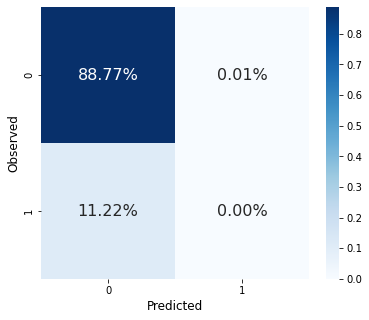

In [27]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

It has high accuracy but awful precision and recall!

#### 2.2.2) Class Weights

The model by default is very conservative and rather not take too many risks in predicting in the positive class.
The solution is to leverage a hyperparameter that forces it to weigh in favor of the positive class more heavily. There are several that can do class weighting but one of them is called `scale_pos_weight`. The default value you can chose is:

$\large{\frac{\text{number of negative samples}}{\text{number of positive samples}}}$

so it's:

In [176]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"default scale pos weight: {def_scale_pos_weight:.2f}")

default scale pos weight: 7.96


This value will indeed make the model perform better but with a sizeable amount of false positives:

Accuracy_train:  0.6381		Accuracy_test:   0.6086
Precision_test:  0.1638		Recall_test:     0.6064
ROC-AUC_test:    0.6458		F1_test:         0.2580		MCC_test: 0.1379


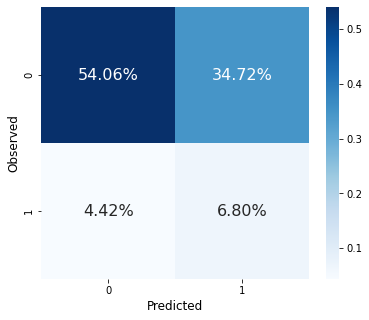

In [29]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)

_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

And if you make it twice as much it will double the false positives:

Accuracy_train:  0.3354		Accuracy_test:   0.3157
Precision_test:  0.1293		Recall_test:     0.8893
ROC-AUC_test:    0.6438		F1_test:         0.2258		MCC_test: 0.0997


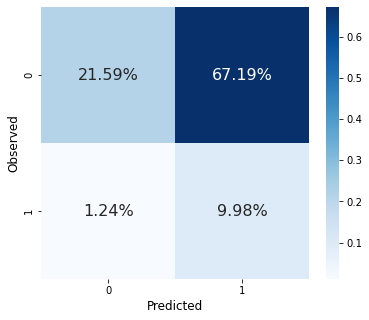

In [30]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

And if you halve it, it will go too much towards the conservative end.

Accuracy_train:  0.8771		Accuracy_test:   0.8617
Precision_test:  0.2232		Recall_test:     0.0937
ROC-AUC_test:    0.6485		F1_test:         0.1320		MCC_test: 0.0782


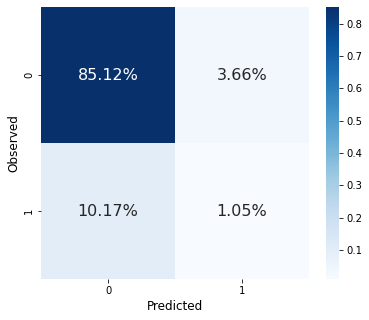

In [31]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

#### 2.2.3) Hyperparameter tuning

Conservative isn't good because the objective is to:

- maximize true positives
- minimize false negatives
- therefore, we favor recall over precision, and
- we rather have much more false positives than false negatives

However, we can't have an extremely high recall to the extent that almost anything is predictive to be in the positive class.

To that end, we should define some constraints. For instance, we should at least have enough true negatives to cover all of those that were never readmitted:

In [32]:
min_tn = X_orig[X_orig['readmitted']=='NO'].shape[0] / X_orig.shape[0]
print(f"Patients % that never readmitted (Minimum % of True Negatives): {min_tn:.2%}")

Patients % that never readmitted (Minimum % of True Negatives): 53.91%


And we are also willing to have as many false positives than those that were readmitted over 30 days, because eventually they will be readmitted.

In [33]:
max_fp = X_orig[X_orig['readmitted']=='>30'].shape[0] / X_orig.shape[0]
print(f"Patients % that were readmitted over 30 days later (Maximum % of False Positives): {max_fp:.2%}")

Patients % that were readmitted over 30 days later (Maximum % of False Positives): 34.93%


**Define optimization fuction**

In the function, in addition to class weights with `scale_pos_weight` we will seek the best hyperparameters for `max_depth` (to limit the tree depth) and L1/L2 regularization with `reg_lambda` and `reg_alpha`. This will help the model generalize better. The objective function outputs `recall` except whenever the two constraints aren't met - in which case it returns a zero.

In [34]:
def optimize_lgb(trial): 
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 11),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    }
    if params['max_depth'] == 11:
        params['max_depth'] = -1

    clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params)
    clf.fit(X_train, y_train)

    metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot=False)

    if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
        return 0

    return metrics_dict['recall']

**Run optimization trials**

This `study` takes about a couple of minutes to run 100 trials with `optuna`, but if there was more time it would be a good idea to change the optimization function so that it averages the recall across cross-validation folds. 

In [35]:
%%time
opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(optimize_lgb, n_trials=100)

[I 2022-10-31 10:44:50,178] A new study created in memory with name: no-name-b7fb71ae-0303-4901-a594-648cb886089b
[I 2022-10-31 10:44:50,886] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 15.159953304838503, 'reg_lambda': 0.0007433466382689736, 'reg_alpha': 1.0246632818395145e-08}. Best is trial 0 with value: 0.0.
[I 2022-10-31 10:44:51,579] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 15.019775541621712, 'reg_lambda': 1.1952576334021075e-05, 'reg_alpha': 1.0647722313552302e-05}. Best is trial 0 with value: 0.0.
[I 2022-10-31 10:44:52,915] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 15.460804376163988, 'reg_lambda': 0.026727077156594108, 'reg_alpha': 3.0634442308277685}. Best is trial 0 with value: 0.0.
[I 2022-10-31 10:44:53,599] Trial 3 finished with value: 0.15211678832116787 and parameters: {'max_depth': 7, 'scale_pos_weight': 4.353779427449652, 'reg_lambda':

CPU times: user 8min 4s, sys: 25.2 s, total: 8min 29s
Wall time: 1min 21s


At the end of the `study`, you can output the best parameters like this:

In [36]:
best_params = opt_study.best_params
print(best_params)

{'max_depth': 11, 'scale_pos_weight': 8.026183223871044, 'reg_lambda': 1.4682871881429613e-06, 'reg_alpha': 1.7620022564235806e-05}


But we will overwrite it with these parameters (for consistency)

In [38]:
best_params = {'max_depth': 7, 'scale_pos_weight': 7.974514084640225, 'reg_lambda': 1.0884781240192942,\
               'reg_alpha': 1.7860457852453339e-06}

#### 2.2.4) Train Tuned Model

Accuracy_train:  0.6340		Accuracy_test:   0.6102
Precision_test:  0.1669		Recall_test:     0.6199
ROC-AUC_test:    0.6484		F1_test:         0.2630		MCC_test: 0.1465


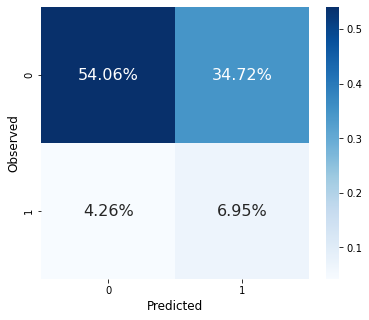

In [40]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         **best_params)
clf.fit(X_train, y_train)

_, y_prob, y_pred = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

## 3) Introduction to Error Analysis

### 3.1) Does it meet the global objective?

If you look closely at the confusion matrix, there are 60% more true positives than false negatives, but at the cost of having a large amount of false positives. However, take in account that because of the constraints we placed, we are hoping that at least half of the true positives would be eventually readmitted (`>30`). 

If this confuses you, look back at the original `readmitted` labels:

In [42]:
X_orig_test['readmitted'].value_counts()

NO     16461
>30    10644
<30     3425
Name: readmitted, dtype: int64

We are predicting `<30` days so our positive class represents this group exclusively. However, a false positive misclassification for `>30` days isn't nearly as bad as one for `NO` readmission. So what proportion of the false positives are `>30` days?

In [43]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred})
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)].value_counts(normalize=True)

readmitted  y_true  y_pred
NO          0       1         0.507581
>30         0       1         0.492419
dtype: float64

Indeed, almost half of the false positives (34.72% of the total test samples) would had been eventually readmitted so taking preventative measures earlier rather than later is not a bad thing. The false positives that should concern us is the other half.  

### 3.2) Splitting Error into Groups/Cohorts

#### 3.2.1) Define Utility Functions for Comparing Errors across Groups

In [127]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan
    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                 index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):

    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),\
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)
    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):
    """Compare two confusion matrices and display FPR ratio metrics. 
    Return FPR ratio between matrices.
    
    Keyword arguments:
    y_true_1 -- ground truth values for first confusion matrix (pandas series or 1D array)
    y_pred_1 -- predictions for first confusion matrix  (pandas series or 1D array)
    y_true_2 -- ground truth values for second confusion matrix (pandas series or 1D array)
    y_pred_2 -- predictions for second confusion matrix  (pandas series or 1D array)
    group_1 -- name of group represented by first matrix (string)
    group_2 -- name of group represented by second matrix (string)
    plot -- whether to plot the confusion matrices or not (boolean)
    """
    
    #Create confusion matrices for two different groups.
    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    #Plot both confusion matrices side-by-side.
    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()

#### 3.2.2) Examine Errors by Group

**Some Demographic Features**

In [110]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='age')

Error breakdown for group 'age'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
age,,,,,,,,
Over 60 years,"20,566",57.3%,16.1%,61.7%,25.5%,62.1%,38.3%,43.3%
30-60 years,"9,201",67.2%,16.9%,59.8%,26.4%,67.5%,40.2%,32.0%
30 years or younger,763,72.0%,23.2%,69.5%,34.8%,77.7%,30.5%,27.8%


In [114]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='gender',\
                         exclude_groups=['Unknown/Invalid'])

Error breakdown for group 'gender'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
gender,,,,,,,,
Female,"16,448",59.6%,16.4%,62.2%,25.9%,64.2%,37.8%,40.7%
Male,"14,080",61.9%,16.5%,60.3%,25.9%,64.8%,39.7%,37.9%


Sometimes it is easier to visualize as confusion matrices placed side by side. 

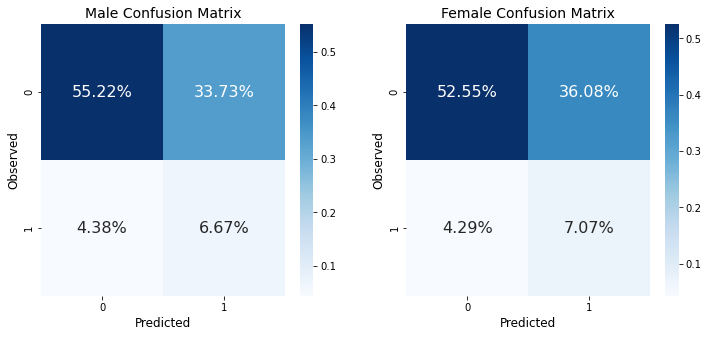

In [128]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male']==1], y_pred[X_test['gender_Male']==1],\
                           y_test[X_test['gender_Female']==1], y_pred[X_test['gender_Female']==1],\
                           'Male', 'Female')

**Some Medical Features**

Perhaps medical features have even more stark differences than demographic features.

In [112]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='admission_source_id')

Error breakdown for group 'admission_source_id'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
admission_source_id,,,,,,,,
Emergency,"17,228",58.0%,16.9%,64.9%,26.8%,64.5%,35.1%,42.9%
Referral,"9,303",64.2%,16.3%,56.2%,25.3%,64.4%,43.8%,34.8%
Other,"3,999",63.8%,14.5%,56.1%,23.1%,63.6%,43.9%,35.4%


In [116]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='had_inpatient_days')

Error breakdown for group 'had_inpatient_days'


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
had_inpatient_days,,,,,,,,
False,"20,292",77.4%,14.1%,32.7%,19.7%,62.0%,67.3%,18.4%
True,"10,238",27.4%,17.5%,90.2%,29.3%,57.1%,9.8%,85.1%


This is very stark. Let's see this as side-by-side confusion matrices to understand what's going on.

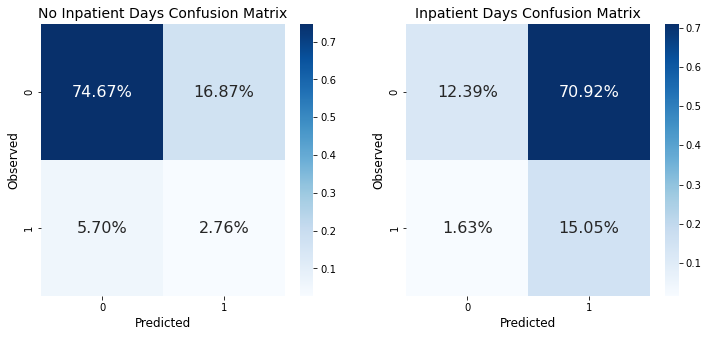

In [129]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days']==0], y_pred[X_test['had_inpatient_days']==0],\
                           y_test[X_test['had_inpatient_days']==1], y_pred[X_test['had_inpatient_days']==1],\
                           'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

Let's see if the subset that does not include `>30` days readmission has similar confusion matrix.

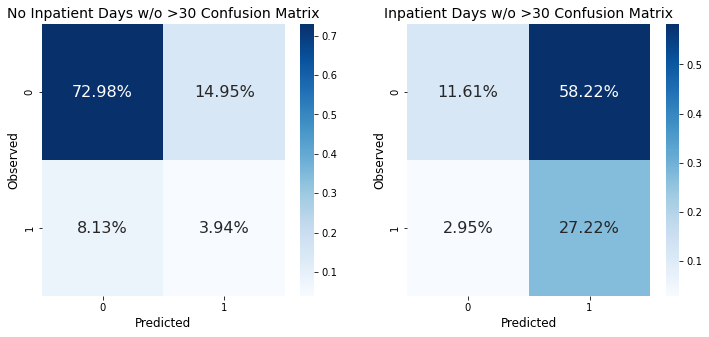

In [130]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')],\
                           y_test[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')],\
                           'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

## 4) Feature Importance and More Advanced Error Analysis

### 4.1) Sample data

For quicker results

In [148]:
X_test_sample = X_test[(X_orig_test['readmitted']!='>30')].sample(frac=0.1)
y_test_sample = y_test.loc[X_test_sample.index]

y_prob_sample = clf.predict_proba(X_test_sample)[:,1]
y_pred_sample = np.where(y_prob_sample > 0.5, 1, 0)

### 4.2) Generate SHAP values

In [149]:
%%time
shap_explainer = shap.Explainer(clf, X_train)
shap_values = shap_explainer(X_test_sample)

CPU times: user 4.7 s, sys: 51.1 ms, total: 4.75 s
Wall time: 4.8 s


They can be accessed like this and are a series of importance attributions:

In [177]:
shap_values.values

array([[ 6.47612171e-02, -1.01174519e-01, -1.03999624e-03, ...,
         0.00000000e+00,  2.22616961e-02,  6.28923066e-05],
       [ 1.43933343e-01, -8.05739947e-02,  1.73199866e-02, ...,
         3.77616221e-04,  2.16264317e-02,  1.76775870e-03],
       [-1.76829297e-01,  2.47330600e-02,  4.14868257e-02, ...,
         0.00000000e+00,  1.03280421e-02,  0.00000000e+00],
       ...,
       [ 3.42066534e-02, -1.08593373e-01, -3.13806080e-02, ...,
         0.00000000e+00,  5.03963822e-02,  0.00000000e+00],
       [-2.97420479e-02,  3.76289746e-02,  5.24862525e-02, ...,
        -5.03488295e-04, -2.84375934e-02, -4.19282075e-05],
       [-1.70505522e-02,  7.74480679e-02,  1.86932694e-02, ...,
         0.00000000e+00,  3.34943613e-02,  3.14461514e-04]])

There's one per observation x feature:

In [179]:
print(shap_values.values.shape)

(1989, 54)


### 4.3) Feature Importance Plots

If you average the absolute values of the SHAP values across one axis, you get a measure of feature importance (one per feature):

In [187]:
np.abs(shap_values.values).mean(axis=0)

array([0.0799555 , 0.07454068, 0.04636593, 0.07801846, 0.06208664,
       0.02122446, 0.00068475, 0.02970372, 0.27623383, 0.00609503,
       0.01176415, 0.00053988, 0.01629008, 0.00543033, 0.00931479,
       0.00774763, 0.01154174, 0.00673513, 0.        , 0.00208199,
       0.0037674 , 0.04339547, 0.19491711, 0.00036428, 0.00548287,
       0.1013347 , 0.00848947, 0.03419953, 0.00695352, 0.00965895,
       0.00580727, 0.00821883, 0.0062429 , 0.01614923, 0.00411641,
       0.01566588, 0.04021655, 0.05129684, 0.00119965, 0.00068253,
       0.00199255, 0.00165545, 0.00900168, 0.00539734, 0.02813363,
       0.00436358, 0.02347725, 0.01201088, 0.00620287, 0.00744782,
       0.00959736, 0.0003648 , 0.05132903, 0.00039404])

This function plots these values for you already ranked:

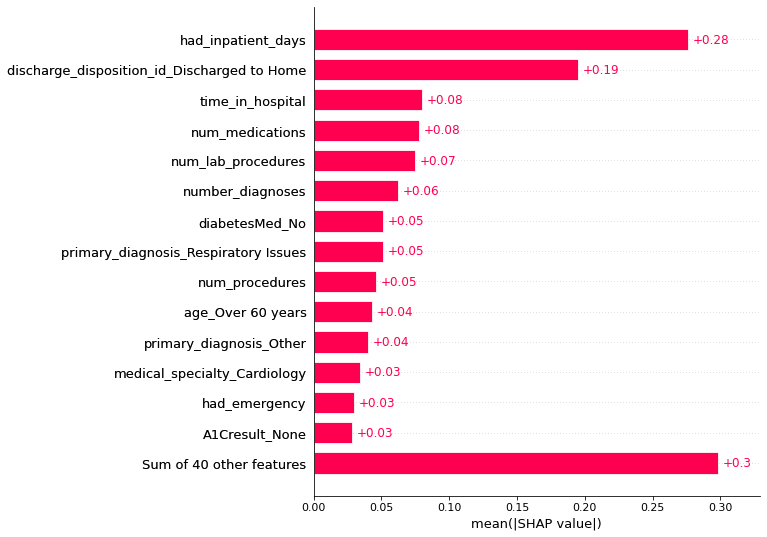

In [150]:
shap.plots.bar(shap_values, max_display=15)

Another way of looking at this plot is as a beeswarm plot where in addition to ranking features by their importance, it shows the distribution of each individual SHAP value and color codes them by the relative value for each feature.

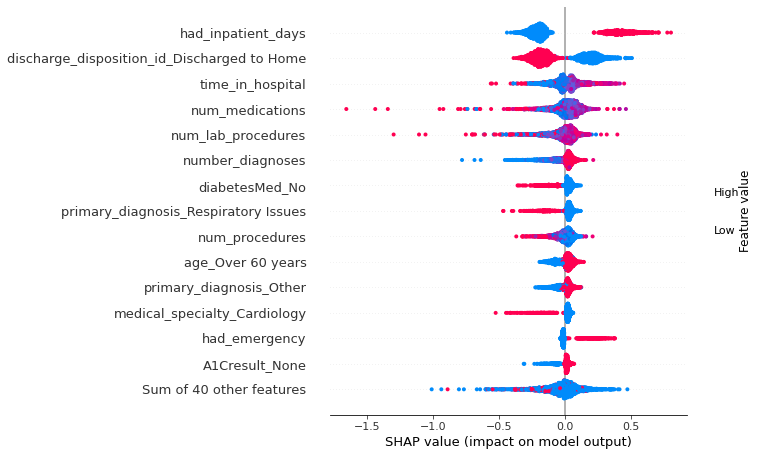

In [151]:
shap.plots.beeswarm(shap_values, max_display=15)

### 4.4) Scatter Plots

Let's take the top continuous features, and scatter plot their SHAP values to show how these change across their values. We can also color code them with the value for `had_inpatient_days` which the model thinks is a strong signal for being classified as readmission `<30` days..

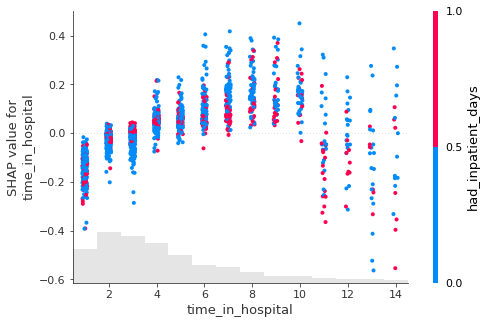

In [160]:
shap.plots.scatter(shap_values[:,"time_in_hospital"],\
                   color=shap_values[:,"had_inpatient_days"])

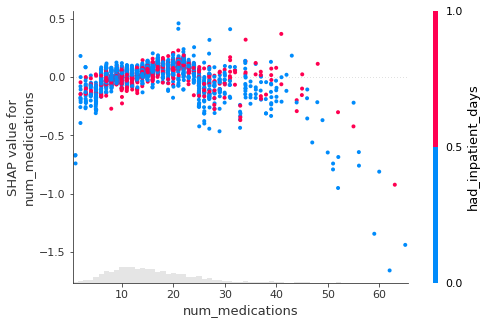

In [153]:
shap.plots.scatter(shap_values[:,"num_medications"],\
                   color=shap_values[:,"had_inpatient_days"])

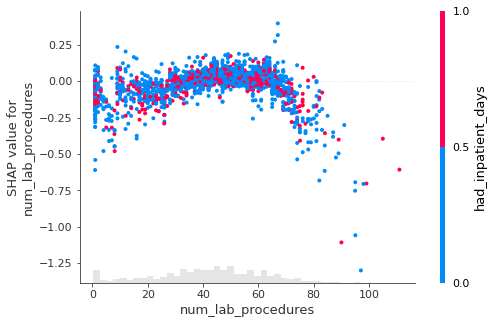

In [155]:
shap.plots.scatter(shap_values[:,"num_lab_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

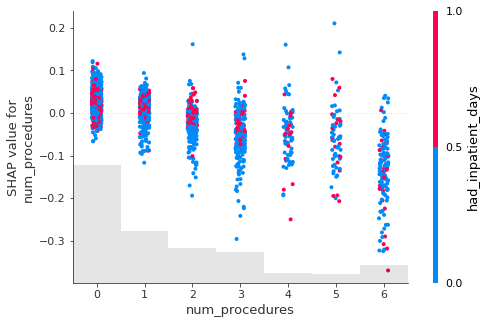

In [157]:
shap.plots.scatter(shap_values[:,"num_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

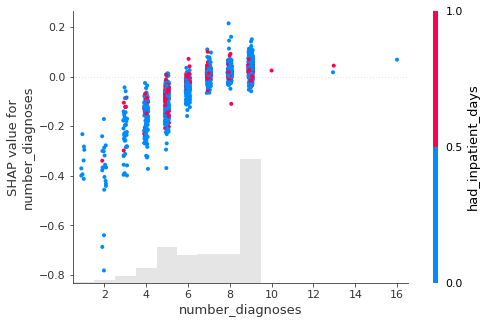

In [158]:
shap.plots.scatter(shap_values[:,"number_diagnoses"], color=shap_values[:,"had_inpatient_days"])

We will now take the values for each of these scatter plots where SHAP values > 0, and use them to create cohorts.

### 4.5) Create Cohorts for Error Analysis Dashboard

To make a cohort, you first create one or more `CohortFilter`, and place these into a `Cohort`. It's like putting two conditions together connected by an "AND". For instance this one is:

$\text{Cohort Mid Time In Hospital} = (\text{had_inpatient_days} > 0) \text{ AND } (4 <= \text{time_in_hospital}) \text{ AND } (\text{time_in_hospital} <= 10)$

In [168]:
cf_had_inpatient_days = CohortFilter(
                            method=CohortFilterMethods.METHOD_GREATER,
                            arg=[0],
                            column='had_inpatient_days')

cf_time_in_hospital = CohortFilter(
                            method=CohortFilterMethods.METHOD_RANGE,
                            arg=[4,10],
                            column='time_in_hospital')

cohort_time_in_hospital = Cohort(name='Cohort Mid Time In Hospital')
cohort_time_in_hospital.add_cohort_filter(cf_had_inpatient_days)
cohort_time_in_hospital.add_cohort_filter(cf_time_in_hospital)

We can now make other ones for these rest of the continuous features:

In [169]:
cf_num_medications = CohortFilter(
                            method=CohortFilterMethods.METHOD_RANGE,
                            arg=[12,24],
                            column='num_medications')
cohort_num_medications = Cohort(name='Cohort Mid # Medications')
cohort_num_medications.add_cohort_filter(cf_had_inpatient_days)
cohort_num_medications.add_cohort_filter(cf_num_medications)

cf_num_lab_procedures = CohortFilter(
                                method=CohortFilterMethods.METHOD_RANGE,
                                arg=[16,71],
                                column='num_lab_procedures')
cohort_num_lab_procedures = Cohort(name='Cohort Mid # Lab Procedures')
cohort_num_lab_procedures.add_cohort_filter(cf_had_inpatient_days)
cohort_num_lab_procedures.add_cohort_filter(cf_num_lab_procedures)

cf_num_procedures = CohortFilter(
                                method=CohortFilterMethods.METHOD_LESS_AND_EQUAL,
                                arg=[1],
                                column='num_procedures')
cohort_num_procedures = Cohort(name='Cohort Low # Procedures')
cohort_num_procedures.add_cohort_filter(cf_had_inpatient_days)
cohort_num_procedures.add_cohort_filter(cf_num_procedures)

cf_num_diagnoses = CohortFilter(
                                method=CohortFilterMethods.METHOD_GREATER_AND_EQUAL,
                                arg=[6],
                                column='number_diagnoses')
cohort_num_diagnoses = Cohort(name='Cohort High # Procedures')
cohort_num_diagnoses.add_cohort_filter(cf_had_inpatient_days)
cohort_num_diagnoses.add_cohort_filter(cf_num_diagnoses)

We then place them in a list:

In [170]:
cohort_l = [cohort_time_in_hospital,
            cohort_num_medications,
            cohort_num_lab_procedures,
            cohort_num_procedures,
            cohort_num_diagnoses]

### 4.6) Initialize the Error Analysis Dashboard

Initialize the `RAIInsights` object.

In [171]:
rai_insights = RAIInsights(model=clf,\
                           train=X_train.join(y_train),\
                           test=X_test_sample.join(y_test_sample),\
                           target_column='readmit_30_days',\
                           task_type='classification')

Then add `error_analysis` and `explainer` to this dashboard:

In [172]:
rai_insights.error_analysis.add(max_depth=4)
rai_insights.explainer.add()
#rai_insights.counterfactual.add(total_CFs=5, desired_class='opposite')

Run `compute` so that it does all the `error_analysis` and `explainer` calculations:

In [173]:
rai_insights.compute()

Once you plug in the `rai_insights` object and cohort list into the `ResponsibleAIDashboard` you will get the dashboard.

In [174]:
ResponsibleAIDashboard(rai_insights, cohort_list=cohort_l)

ResponsibleAI started at http://localhost:5010


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-de

### 4.7) Possible Error Mitigation Strategies

#### 4.7.1) Post-processing (predictions)

This can be kind of "hacky" but you can always change the threshold for when the predict the positive class. It doesn't consistently have to be 0.5. You can have cohorts with different thesholds. You can also calibrate the probabilities themselves to minimize error in the weaker spots.

In [220]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'had_inpatient_days':X_test['had_inpatient_days'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred,
                         'y_prob':y_prob})
preds_df = preds_df[(preds_df['readmitted']!='>30')]

preds_df['y_pred_new'] = np.where(preds_df.had_inpatient_days==0,\
                                  np.where(preds_df.y_prob > 0.45, 1, 0),
                                  np.where(preds_df.y_prob > 0.59, 1, 0))

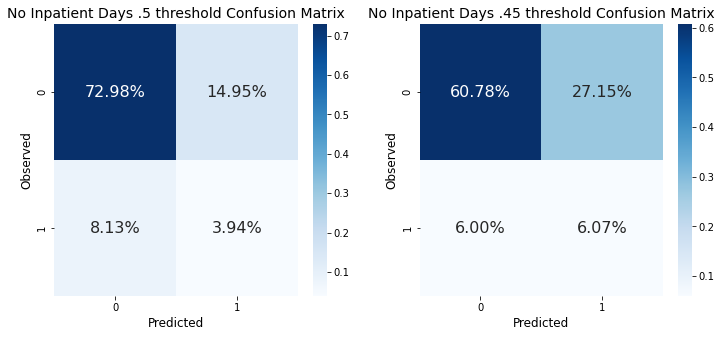

In [221]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred_new'],
                               'No Inpatient Days .5 threshold', 'No Inpatient Days .45 threshold')

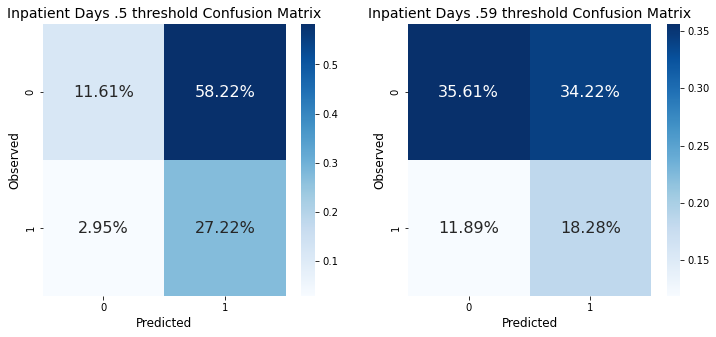

In [219]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred_new'],
                               'Inpatient Days .5 threshold', 'Inpatient Days .59 threshold')

#### 4.7.2) In-processing (model)

- Use `sample_weight` to force the model to focus more on the samples where it is weakest
- Leverage a custom `loss` function that penalizes false negatives differently depending on the cohort
- Try a multi-class classification model instead. Perhaps seperating `NO` and `>30` allows for the model to perform better.

#### 4.7.3) Pre-processing (data)

- Review errors with domain experts and find new widely available features that can help discriminate better (perhaps the year or time of year makes a difference)
- Maybe some previously engineered features destroyed the signal. For instance, age is in age groups but smaller groups or actual age would reduce error in the specific cases examined.

## 5) Read More

- [Responsible AI Toolbox Website](https://responsibleaitoolbox.ai/)
- [Responsible AI Github Repository](https://github.com/microsoft/responsible-ai-toolbox)
- [Responsible AI Dashboard: Census Error Analysis Example](https://github.com/microsoft/responsible-ai-toolbox/blob/main/notebooks/responsibleaidashboard/responsibleaidashboard-census-classification-model-debugging.ipynb)
- [Responsible AI Dashboard: Counterfactual Diabetes Example](https://github.com/microsoft/responsible-ai-toolbox/blob/main/notebooks/responsibleaidashboard/responsibleaidashboard-diabetes-decision-making.ipynb)
- [SHAP Beeswarm Plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html)